# Linear regression baseline

In this notebook, we will create the linear regression baselines.

In [3]:
%load_ext autoreload
%autoreload 2

#import sys
#sys.path.insert(0, "/g/data/wb00/admin/testing/weatherbench/notebooks")
import os
#os.chdir("/g/data/wb00/admin/testing/weatherbench/notebooks")
#os.chdir("/g/data/wb00/admin/testing/weatherbench/NCI_notebooks/")
NOTEBOOK_DIR="/g/data/wb00/admin/testing/weatherbench/NCI_notebooks"
os.chdir(NOTEBOOK_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
#import cupy
#import cupy_xarray
import glob 
#import multiprocessing
from datetime import datetime
from dask.diagnostics import ProgressBar
from dask.distributed import Client
client = Client(n_workers=12, threads_per_worker=1)  
client

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

<Client: 'tcp://127.0.0.1:42243' processes=12 threads=12, memory=191.00 GiB>

In [12]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [13]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

## Load and prepare data for training

First up, we need to load and prepare the data so that we can feed it into our linear regression model.

In [14]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
#DATADIR = '/data/WeatherBench/5.625deg/'
#PREDDIR = '/data/WeatherBench/baselines/'
# DATADIR = '/data/stephan/WeatherBench/5.625deg/'
# PREDDIR = '/data/stephan/WeatherBench/baselines/'
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print(DATADIR)
#PREDDIR = '/tmp/NCI-Weatherbench/baselines/' 
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print(PREDDIR)
! mkdir -p {PREDDIR} 
! mkdir -p {PREDDIR+"/saved_models"} 
#REF_BASELINE = '/g/data/wb00/admin/testing/weatherbench/dataserv.ub.tum.de/baselines/'

#START = -13
#END   = None
#get_files_list = lambda x: [f for f in sorted( glob.glob(f'{DATADIR}{x}*.nc') )][:5]
#get_files_list(f'{DATADIR}geopotential/',-12,None)
#! ls {PREDDIR} 

/g/data/wb00/NCI-Weatherbench/5.625deg
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir


In [15]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
#z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
#t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t.drop('level')
#tp = xr.open_mfdataset(f'{DATADIR}total_precipitation/*.nc', combine='by_coords').tp.rolling(time=6).sum() 
#t2m = xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords').t2m
#with ProgressBar():
z500 = xr.open_mfdataset(get_files_list(f'{DATADIR}/geopotential/'), combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(get_files_list(f'{DATADIR}/temperature/'),  combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()    
tp   = xr.open_mfdataset(get_files_list(f'{DATADIR}/total_precipitation/'), combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
tp.name = 'tp'
t2m  = xr.open_mfdataset(get_files_list(f'{DATADIR}/2m_temperature/'), combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load() 
data = xr.merge([z500, t850, tp, t2m]).compute()

[2024-02-10 17:20:43]
CPU times: user 19min 29s, sys: 1min 42s, total: 21min 11s
Wall time: 27min 45s


In [16]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Load the validation subset of the data: 2017 and 2018
#z500_test = load_test_data(f'{DATADIR}geopotential_500', 'z')
#t850_test = load_test_data(f'{DATADIR}temperature_850', 't')

z500_test = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022'))
t850_test = load_test_data(f'{DATADIR}/temperature/',  't',  slice('2021', '2022'))
tp_test   = load_test_data(f'{DATADIR}/total_precipitation/', 'tp', slice('2021', '2022')).rolling(time=6).sum()
tp_test.name = 'tp'
t2m_test  = load_test_data(f'{DATADIR}/2m_temperature/', 't2m', slice('2021', '2022'))
#with ProgressBar():    
test_data = xr.merge([z500_test, t850_test, tp_test, t2m_test]).compute()

[2024-02-10 17:48:29]
var: z
var: t
var: tp
var: t2m
CPU times: user 27.7 s, sys: 1.8 s, total: 29.5 s
Wall time: 33 s


In [17]:
data.tp[:6+7+1] 

<xarray.DataArray 'tp' (time: 14, lat: 32, lon: 64)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [5.4629147e-04, 5.7158293e-04, 9.9113595e-04, ...,
         5.0149338e-05, 1.0921620e-05, 3.5016838e-04],
        [2.0135217e-06, 5.7537579e-07, 8.6277742e-06, ...,
         1.6049798e-04, 4.5116991e-05, 5.2595133e-05],
        [1.3791025e-05, 1.5230073e-05, 1.5229920e-05, ...,
         6.0433831e-06, 2.5900099e-06, 1.3791025e-05]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0072098e-06, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 2.8792701e-07, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [6.4112432e-04, 6.7748124e-04, 1.2721830e-03, ...,
         5.5034441e-05, 1.2069941e-05, 3.6741176e-04],
        [2.3003695e-06, 5.7537579e-07, 8.6277742e-06, ...,
         1.6308545e-04, 4.8853457e-05, 5.4897366e-05],
        [1.3791025e-05, 1.5517884e-05, 1.5517699e-05, ...,
         6.9066882e-06, 2.5900099e-06, 1.3791025e-05]]], dtype=float32)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1959-01-01 ... 1959-01-01T13:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

In [18]:
# The first 7+6 values of tp are missing, so let's just start after that
data.tp[:6+7+1].mean(('lat', 'lon')).compute()


<xarray.DataArray 'tp' (time: 14)>
array([       nan,        nan,        nan,        nan,        nan,
       0.000504  , 0.00050462, 0.00051301, 0.00052964, 0.0005507 ,
       0.00057175, 0.00059542, 0.00061806, 0.00062765], dtype=float32)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1959-01-01 ... 1959-01-01T13:00:00

In [19]:
data = data.isel(time=slice(7+6, None))

In [20]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Split into train and test data
# Yes, technically we should have a separate validation set but for LR this shouldn't matter.
#data_train = data.sel(time=slice('1979', '2016'))
# data_train = data.sel(time=slice('2016', '2016'))
#data_test = data.sel(time=slice('2017', '2018'))
data_train = data.sel(time=slice('1959', '2020'))

data_test = data.sel(time=slice('2021', '2022'))

[2024-02-10 17:49:02]
CPU times: user 29.2 ms, sys: 1.52 ms, total: 30.7 ms
Wall time: 25.9 ms


In [21]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().compute() #.load()
data_std  = data_train.isel(time=slice(0, None, 10000)).std().compute() #.load()

[2024-02-10 17:49:02]
CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 4.5 ms


In [22]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test  = (data_test - data_mean) / data_std

[2024-02-10 17:49:02]
CPU times: user 10.2 s, sys: 13.6 s, total: 23.8 s
Wall time: 19.7 s


In [23]:
_, nlat, nlon = data_train.z.shape; nlat, nlon

(32, 64)

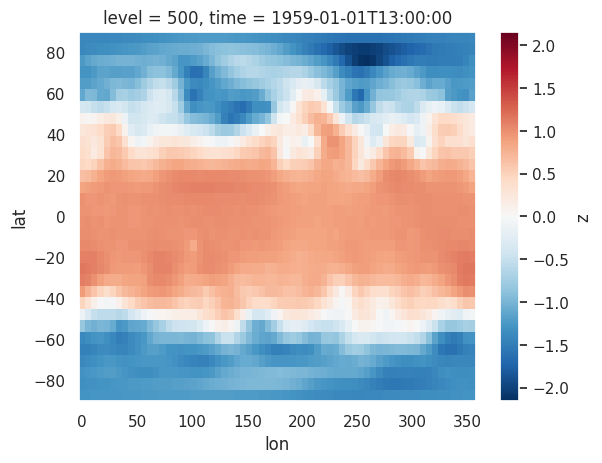

In [24]:
data_train.z.isel(time=0).plot()

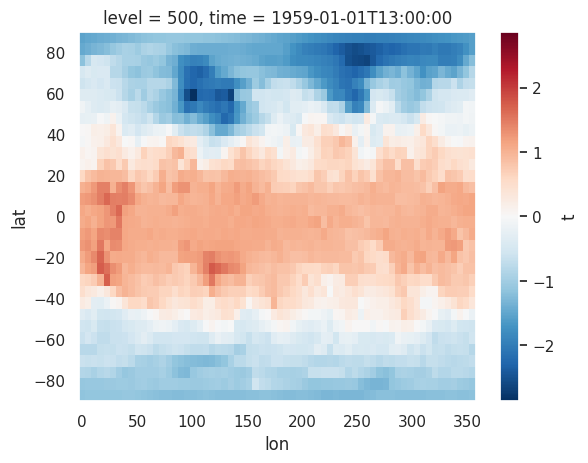

In [25]:
data_train.t.isel(time=0).plot()

In [26]:
data_train

<xarray.Dataset>
Dimensions:  (time: 543491, lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1959-01-01T13:00:00 ... 2020-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 -1.286 -1.282 -1.279 ... -0.8063 -0.7838
    t        (time, lat, lon) float64 -1.159 -1.129 -1.122 ... -0.8096 -0.8351
    tp       (time, lat, lon) float64 -0.3198 -0.3198 ... -0.1547 -0.1741
    t2m      (time, lat, lon) float64 -1.532 -1.554 -1.581 ... -0.6093 -0.5723

In [27]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

## Train linear regression

Now let's train the model. We will use scikit-learn for this.

In [28]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        X, y = create_training_data(
            data_train[v],
            lead_time_h
        )
        
        X_train.append(X)
        if v in output_vars: y_train.append(y)
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
        if v in output_vars: y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
    
    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]
    
    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr   

### 3 days

Here we train a model to directly predict the fields at 3 days lead time. Let's train a model that only predicts z or t and then a combined model. As we can see below, the model trained only on Z500 performs better than the combined model. But the same is not the case for T850.  

In [29]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

experiments = [
    [['z'], ['z']],
    [['t'], ['t']],
    [['z', 't'], ['z', 't']],
    [['tp'], ['tp']],
    [['z', 't', 'tp'], ['tp']],
    [['t2m'], ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

[2024-02-10 17:49:23]
CPU times: user 156 µs, sys: 30 µs, total: 186 µs
Wall time: 151 µs


In [30]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Since training the LR on the full data takes up quite a lot of memory 
# we only take every 5th time step which gives almost the same results (<0.5% difference)
data_subsample = 5
lead_time = 3*24
preds  = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) ) # + '\n')
    # Write
    print('Saving:', f'{PREDDIR}/lr_3d_{"_".join(i)}_{"_".join(o)}.nc' )
    p.to_netcdf(f'{PREDDIR}/lr_3d_{"_".join(i)}_{"_".join(o)}.nc');
    print('Saving:', f'{PREDDIR}/saved_models/lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')
    to_pickle(m, f'{PREDDIR}/saved_models/lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')
    print('\n')

[2024-02-10 17:49:23]
0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.04992666080097788
Test MSE = 0.05779451008106193
z = 682.2056091501111
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_3d_z_z.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_3d_z_z.pkl


1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.04526987943669513
Test MSE = 0.051928453386798336
t = 3.153037112471175
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_3d_t_t.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_3d_t_t.pkl


2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.041918428899370704
Test MSE = 0.05527445958394122
z = 690.9223353366928; t = 3.1018083320096497
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_3d_z_t_z_t.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_3d_z_t_z_t.pkl


3: Input variables = ['tp']; output variables = ['tp']
Train MSE

As we can see the models with just the output variable as input almost always perform better because of overfitting. We could try a regularized regression like ridge of lasso but the point of these models not to be good but rather to provide a solid baseline with as few hyperparameters as possible.

### 5 days

In [31]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
print('Same for 5 days')
data_subsample = 5
lead_time = 5*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) )# + '\n')
    print('Saving:', f'{PREDDIR}/lr_5d_{"_".join(i)}_{"_".join(o)}.nc'); 
    p.to_netcdf(f'{PREDDIR}/lr_5d_{"_".join(i)}_{"_".join(o)}.nc');
    print('Saving:', f'{PREDDIR}/saved_models/lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')
    to_pickle(m, f'{PREDDIR}/saved_models/lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')
    print('\n')

[2024-02-10 18:22:57]
Same for 5 days
0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.06316251077335788
Test MSE = 0.07283380637189146
z = 766.9912110807041
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_5d_z_z.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_5d_z_z.pkl


1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.05232560341332795
Test MSE = 0.06059225786157582
t = 3.399226450044427
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_5d_t_t.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_5d_t_t.pkl


2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.05194430171061613
Test MSE = 0.06947025707256141
z = 786.1182984338043; t = 3.4296236354807634
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_5d_z_t_z_t.nc
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_5d_z_t_z_t.pkl


3: Input variables = ['tp']; output variables = ['

### Iterative forecast

Finally, an iterative forecast. First, we train a model for 6 hours lead time and then construct an iterative forecast up to 120 hours.

In [32]:
def create_iterative_fc(state, model, lead_time_h=6, max_lead_time_h=5*24):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs_z500, fcs_t850 = [], []
    for fc_step in tqdm(range(max_fc_steps)):
        state = model.predict(state)
        fc_z500 = state[:, :nlat*nlon].copy() * data_std.z.values + data_mean.z.values
        fc_t850 = state[:, nlat*nlon:].copy() * data_std.t.values + data_mean.t.values
        fc_z500 = fc_z500.reshape((-1, nlat, nlon))
        fc_t850 = fc_t850.reshape((-1, nlat, nlon))
        fcs_z500.append(fc_z500); fcs_t850.append(fc_t850)

    return [xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': z500_test.time,
            'lat': z500_test.lat,
            'lon': z500_test.lon
        }
    ) for fcs in [fcs_z500, fcs_t850]]

In [33]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
p, m = train_lr(6, input_vars=['z', 't'], output_vars=['z', 't'], data_subsample=5)

[2024-02-10 18:55:11]
Train MSE = 0.0038254103556393405
Test MSE = 0.004254386444901913
CPU times: user 7min 23s, sys: 22.7 s, total: 7min 46s
Wall time: 7min 24s


In [34]:
print('Saving:', f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')
to_pickle(m,     f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')

Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/saved_models/lr_6h_z_t_z_t.pkl


In [35]:
m = read_pickle(f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')

In [36]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
state = np.concatenate([data_test.z.values.reshape(-1, nlat*nlon), 
                        data_test.t.values.reshape(-1, nlat*nlon)], 1)

[2024-02-10 19:02:36]
CPU times: user 108 ms, sys: 122 ms, total: 231 ms
Wall time: 187 ms


In [37]:
fc_z500_6h_iter, fc_t850_6h_iter = create_iterative_fc(state, m)

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
fc_iter = xr.Dataset({'z': fc_z500_6h_iter, 't': fc_t850_6h_iter})
print('Saving:',  f'{PREDDIR}/lr_6h_iter.nc');
fc_iter.to_netcdf(f'{PREDDIR}/lr_6h_iter.nc');

[2024-02-10 19:04:53]
Saving: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/lr_6h_iter.nc
CPU times: user 1.46 s, sys: 8.47 s, total: 9.93 s
Wall time: 8.78 s


# The End